<div class="alert alert-success">
Important: Some of this project is pre-code, and may not fully reflect how my projects would usually look.

# Good Seed Supermarkets

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

- The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
- Computer vision methods can be used to determine age of a person from a photo
- The task then is to build and evaluate a model for verifying people's age

To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Initialization

In [1]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

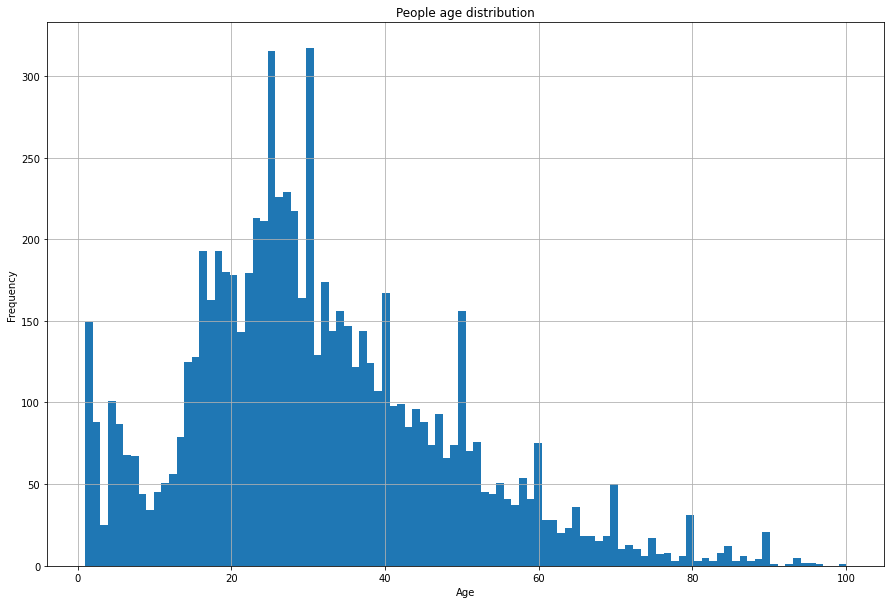

In [5]:
df['real_age'].hist(bins=100, figsize=(15, 10))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('People age distribution')
plt.show()

(114, 114, 3)


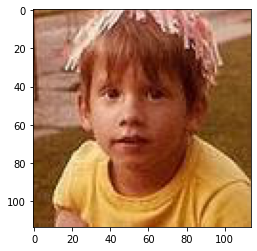

(784, 784, 3)


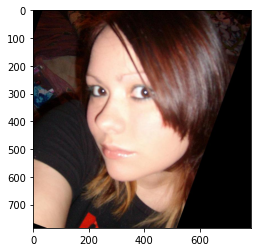

(133, 133, 3)


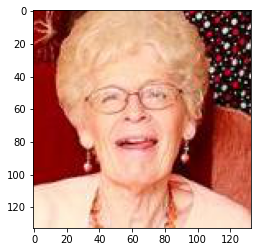

In [6]:
for i in range(3):
    if i < 10:
        number = '0' + str(i)
    else:
        number = i
        
    image = np.array(Image.open(f'/datasets/faces/final_files/0000{number}.jpg'))
    print(image.shape)
    
    plt.imshow(image)
    plt.show()

### Findings

The images being used for our neural network is comprised of different picture sizes, the majority of ages are in the range of about 16-35 though while this does represent a realistic majority of ages it is still a class imbalance.

<div class="alert alert-block alert-info">
<b>Improve: </b> It would be better if ages were inserted into titles.
</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1 / 255, validation_split=0.25)
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=df,
        directory=path + 'final_files/', x_col='file_name', y_col='real_age', 
        target_size=(150, 150), batch_size=16, class_mode='raw', 
        subset='training', seed=12345, horizontal_flip=True, vertical_flip= True)

    return train_gen_flow

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1 / 255, validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=df, 
        directory=path + 'final_files/', x_col='file_name', y_col='real_age', 
        target_size=(150, 150), batch_size=16, class_mode='raw', 
        subset='validation', seed=12345)

    return test_gen_flow


def create_model(input_shape=(150, 150, 3)):
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(68, activation='relu')) 
    model.add(Dense(68, activation='relu')) 
    model.add(Dense(34, activation='relu'))
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0005)
    model.compile(
        loss='mse', metrics=['mae'], optimizer=optimizer,
    )

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - 62s - loss: 239.4785 - mae: 11.5966 - val_loss: 416.3819 - val_mae: 15.3916

Epoch 2/10

356/356 - 44s - loss: 132.7786 - mae: 8.8082 - val_loss: 219.3315 - val_mae: 10.9985

Epoch 3/10

356/356 - 44s - loss: 89.9602 - mae: 7.3176 - val_loss: 129.3296 - val_mae: 8.8860

Epoch 4/10

356/356 - 41s - loss: 64.7987 - mae: 6.2026 - val_loss: 140.3195 - val_mae: 8.7891

Epoch 5/10

356/356 - 41s - loss: 41.6851 - mae: 4.9974 - val_loss: 102.8835 - val_mae: 7.8438

Epoch 6/10

356/356 - 42s - loss: 27.8507 - mae: 4.0806 - val_loss: 133.4632 - val_mae: 8.4594

Epoch 7/10

356/356 - 43s - loss: 22.9430 - mae: 3.6846 - val_loss: 91.5954 - val_mae: 7.2580

Epoch 8/10

356/356 - 43s - loss: 18.7668 - mae: 3.3406 - val_loss: 119.0396 - val_mae: 8.0149

Epoch 9/10

356/356 - 44s - loss: 15.5073 - mae: 3.0373 - val_loss: 93.8352 - val_mae: 7.3502

Epoch 10/10

356/356 - 44s - loss: 14.9843 - mae: 2.9403 - val_loss: 92.8262 - val_mae: 7.3657

119/119 - 10s - loss: 92.8262 - mae: 7.3657

Test MAE: 7.3657

## Conclusions

Our model used the ResNet neural network, which alongside a few dense layers allowed us to achieve a minimal MAE of 7.36. It should be noted that, unfortunately, the simulator does not allow you to improve the result after reaching the required MAE value. In case this were possible, it would be worth trying to use different augmentations, change the learning rate values, add regularization and change the number of epochs. Perhaps this would improve the result, and definitely reduce the degree of retraining.